# Params #  
X -> m-by-n matrix of net returns (samples-by-assets)  
r -> m-dimensional vec of net returns of index  
reg -> sparsity regularization parameter  
u -> upper bound of weights  
w_0 -> initial point  
p_neg_exp -> final negative exponent of p  
max_iter -> max number of iterations  

return n-dimensional vector w/ allocation weights on the assets  

In [36]:
# TODO: Add support for other indices besides S&P (maybe just simple if-else switches or passing supported index parameters)
# TODO: Consider hw to improve sparsity in portfolio cardinality
# TODO: Clean up debug print statements
# TODO: Discuss potential drawbacks (if S&P performs terribly then it will be reflected, which happened in the 2022-01-01 to 2023-01-01 timeframe); Weird bug with 2023-03-01 and onwards, also with 2020-01-01, not sure what the issue is; might be smth to do with inc/exc bounds

In [77]:
import torch
import math
from sec import stock, constants, lookups
from polygon import RESTClient
import yfinance as yf # temporary until we figure out polygon api
import scipy
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [38]:
constants.set_polygon_key("_4BtZn3PRCLu6fsdu7dgddb4ucmB1sfp")
poly_cli = RESTClient(api_key="_4BtZn3PRCLu6fsdu7dgddb4ucmB1sfp")
torch.set_default_dtype(torch.float64)

In [39]:
curr_sp = lookups.get_sp500_tickers("2015-01-01")
print(len(curr_sp))
print(curr_sp)

499
['A', 'AABA', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'ADT', 'AEE', 'AEP', 'AES', 'AET', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AKAM', 'ALL', 'ALLE', 'ALTR', 'ALXN', 'AMAT', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANDV', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'APTV', 'ARG', 'ARNC', 'ATI', 'AVB', 'AVGO', 'AVP', 'AVY', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBBY', 'BBT', 'BBY', 'BCR', 'BDX', 'BEN', 'BF.B', 'BHGE', 'BIIB', 'BK', 'BKNG', 'BLK', 'BLL', 'BMY', 'BRCM', 'BRK.B', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH', 'CAM', 'CAT', 'CB', 'CBRE', 'CBS', 'CCE', 'CCI', 'CCL', 'CELG', 'CERN', 'CF', 'CFN', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNP', 'CNX', 'COF', 'COG', 'COL', 'COP', 'COST', 'COV', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVC', 'CVS', 'CVX', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DLTR', 'DNB', 'DNR', 'DO', 'DOV'

In [40]:
# aggregate all close data (has been modularized below)
# TODO: remove later after backtesting
# close_data = torch.zeros((252, len(curr_sp)))

# for i in range(len(curr_sp)):
#     aggs = []
#     data = poly_cli.list_aggs(ticker=curr_sp[i], multiplier=1, timespan="day", from_="2023-02-01", to = "2024-02-01")
#     for j, agg in enumerate(data):
#         close_data[j, i] = agg.close

# print(close_data)

In [41]:
# torch.set_default_dtype(torch.float64)

# col_dim = close_data.shape[0]
# return_data = torch.zeros((252, len(curr_sp)))
# for i in range(1, col_dim):
#     return_data[i] = (close_data[i, :] - close_data[0, :])/close_data[0, :]
# print(return_data)

In [42]:
# @param start -> "YYYY-MM-DD"
# source: https://www.tradinghours.com/publications/trading-days-per-year
# unsure of source accuracy
def getTradingDays(start):
    year = start[0:4]

    # hardcode trading days per year
    tradingDays = {
        2023: 252,
        2022: 252,
        2021: 252,
        2020: 253,
        2019: 252,
        2018: 251,
        2017: 251,
        2016: 252,
        2015: 252,
        2014: 252,
        2013: 252,
        2012: 250,
        2011: 252,
        2010: 252
    }

    return tradingDays.get(year, 252)

In [103]:
# @param start -> "YYYY-MM-DD"
# calculates
def getCloseData(start, period=1):
    # lookup_period = start[0:4] + "-12-31"
    if period == 0.5:
        lookup_period = (datetime.strptime(start, "%Y-%m-%d") + relativedelta(months=6)).strftime("%Y-%m-%d")
        total_days = getTradingDays(start) // 2
    else:
        lookup_period = (datetime.strptime(start, "%Y-%m-%d") + relativedelta(years=period)).strftime("%Y-%m-%d")
        total_days = getTradingDays(start)


    curr_sp = lookups.get_sp500_tickers(lookup_period)
    # total_days = 0
    # for i in range(period):
    #     begin = str(int(start[0:4]) + i) + start[4:]
    #     total_days += getTradingDays(begin)
    close_data = torch.zeros((total_days, len(curr_sp)))
    if period == 0.5:
        end = (datetime.strptime(start, "%Y-%m-%d") + relativedelta(months=6)).strftime("%Y-%m-%d")
    else:
        end = (datetime.strptime(start, "%Y-%m-%d") + relativedelta(days=1)).strftime("%Y-%m-%d")

    # end = str(int(start[0:4]) + period) + start[4:]

    for i in range(len(curr_sp)):
        # aggs = []
        data = poly_cli.list_aggs(ticker=curr_sp[i], multiplier=1, timespan="day", from_=start, to = end)
        # print(len(list(data)))
        for j, agg in enumerate(data):
            # if j == total_days - 1:
            #     break
            # print()
            if j >= total_days:
                break
            close_data[j, i] = agg.close
    return close_data

# close = getCloseData("2023-02-01")

In [ ]:
test = getCloseData("2020-01-01", period=0.5)

In [101]:
test.shape

torch.Size([252, 505])

In [87]:
def calculateTickerReturns(start, period=1):
    close_data = getCloseData(start, period)
    col_dim = close_data.shape[0]
    return_data = torch.zeros((close_data.shape[0], close_data.shape[1]))
    for i in range(1, col_dim):
        return_data[i] = (close_data[i, :] - close_data[0, :])/close_data[0, :]
    return return_data

In [88]:
def collectSP500(start, period=1):
    index_symbol = "^GSPC"
    if period == 0.5:
        end =(datetime.strptime(start, "%Y-%m-%d") + relativedelta(months = 6)).strftime("%Y-%m-%d")
        total_days = getTradingDays(start) // 2
    else:
        end = str(int(start[0:4]) + period) + start[4:]
        total_days = getTradingDays(start)

    index_data = yf.download(index_symbol, start=start, end=end, interval="1d")
    index_close_data = torch.tensor(index_data["Close"].values)

    # total_days = 0
    # for i in range(period):
    #     begin = str(int(start[0:4]) + i) + start[4:]
    #     total_days += getTradingDays(begin)
    index_close_data = index_close_data[:total_days]
    return index_close_data

In [90]:
def calculateIndexReturns(start, period=1):
    index_data = collectSP500(start, period)
    dim = index_data.shape[0]
    return_data = torch.zeros(dim)
    for i in range(1, dim):
        return_data[i] = ((index_data[i] - index_data[0])) / index_data[0]
    return return_data.reshape(dim, 1)

In [91]:
def preparePipeline(start, period=1):
    if period == 0.5:#signifies testing over 6 months
        ticker_returns = calculateTickerReturns(start, period)
        index_returns = calculateIndexReturns(start, period)
    else:
        ticker_returns = calculateTickerReturns(start, period)
        index_returns = calculateIndexReturns(start, period)
    return ticker_returns, index_returns
# test, test2 = preparePipeline("2023-03d-02")

# Algorithm #

In [49]:
# funcition to solve kkt
def bisection(c, u):
  n = len(c)
  w = torch.zeros(n) # new weight vector
  c_sort, sort_indices = torch.sort(c)
  
  high = n - 1
  low = 0

  while low <= high:
    mid = (low + high) // 2
    if mid == 0:
      break
    mu = -1/mid * (torch.sum(c_sort[0:mid]) + 2)

    cond1 = (mu + c_sort[mid] < 0).item()

    if mid < n:
      cond2 = torch.all((mu + c_sort[mid] >= 0)).item()
    else:
      cond2 = True

    if cond1 and cond2:
      break
    elif cond1 and not cond2:
      low = mid + 1
    else:
      high = mid - 1

  new_values = -(mu + c_sort[:mid] / 2)
  if torch.all(-(mu + c_sort[:mid])/2 <= u).item():
      # print(f"This is w.shape in bisection: {w.shape}")
      # print(f"This is what is getting put in w in bisecttion: {(-(mu + c_sort[:mid])/2).shape}")
      w[sort_indices[:mid]] = -(mu + c_sort[:mid])/2
      # print("We get to the if and this is executed")
      # print(w)
      # print(w.shape)
      return w
  else:
    flag = False
    flag2 = False
    k = mid

    while True:
      low1 = 0
      high1 = k - 1

      while low1 <= high1:
        mid1 = (low1 + high1) // 2
        mu = (2 * mid1 * u - torch.sum(c_sort[mid1:k]) - 2) / (k - mid1)

        if mid1 != 0:
          cond1 = torch.all((mu + c_sort[mid1] <= -2*u)).item()
        else:
          cond1 = True

        cond2 = torch.all(((-2 * u) < (mu + c_sort[mid1]))).item() and torch.all(((mu + c_sort[k - 1]) < 0)).item()

        if k < n:
          cond3 = torch.all((mu + c_sort[k]) >= 0).item()
        else:
          cond3 = True

        if cond1 and cond2 and cond3:
          flag = True
          break
        elif cond1 and not cond2:
          low1 = mid1 + 1
        else:
          high1 = mid1 - 1

      if flag:
        break
      else:
        k = k + 1

      if k > n:
        flag2 = True
        break

    if flag2:
      num_elements = int(torch.ceil(torch.tensor(1/u)))
      w[sort_indices[:num_elements]] = u
    else:
      w[sort_indices[:mid1]] = u
      w[sort_indices[mid1:k]] = -(mu + c_sort[mid1:k]) / 2
    # print("we got to this new territory")
    # print(f"w in bisection: {w.shape}")
    return w

In [50]:
# increasing the weight
def eteMMupdate(w, B, b, Lmax_A, reg, p , c_1, u, m, n):
  # print(f"w: {w}")
  # print(f"B: {B}")
  # print(f"b: {b}")
  # print(f"Lmax_A: {Lmax_A}")
  # print(f"reg: {reg}")
  # print(f"p: {p}")
  # print(f"c_1: {c_1}")
  # print(f"u: {u}")
  d = reg / ((p + abs(w)) * c_1)
  # print(f"d: {d}")
  c = B @ w + 1/Lmax_A * (b + d) # calculation for q_ete, tracking error, 503 x 503 @ 503 x 1 + 
  
  # print(f"This is c.shape {c.shape}")
  c = c.reshape(n)
  # print(f"This is c after reshape in eteMMupdate {c.shape}")
  # print(f"c: {c}")

  return bisection(c,u)

In [51]:
def track(data, returns, reg, thres = 1e-6, u = 1, w_0 = None, p_neg_exp = 7, max_iter = 1000):
  # error check
  # make sure returns matrix and index vector have matching dimensions
  if (data.shape[0] != returns.shape[0]):
    if data.shape[0] > returns.shape[0]:
      data = data[:returns.shape[0]]
    else:
      returns = returns[:data.shape[0]]
    # print(data.shape[1])
    # print(returns.shape[0])
    # raise Exception("Returns matrix and index vector do not have matching dimensions! Error.")

  X = data.double()

  nan_count = torch.isnan(X).sum().item()
  # print(f"Number of NaNs in the original matrix: {nan_count}")

  # cleaning up NaN
  def fill_with_rolling_mean(series, window_size=10):
    temp_series = series.copy()
    rolling_means = temp_series.rolling(window_size, min_periods=1, center=True).mean()
    return series.fillna(rolling_means)
  
  X_df = pd.DataFrame(X.numpy())
  X_df_filled = X_df.apply(fill_with_rolling_mean, axis=1)
  # print(X_df_filled.shape)

  # nan_count = X_df_filled.isna().sum().sum()
  # print(f"Number of NaNs in the X_df_filled matrix: {nan_count}")

  X_df.where(pd.notna(X_df), X_df_filled, inplace=True)
  # print(X_df.shape)
  X = torch.tensor(X_df.to_numpy())
  # nan_count = torch.isnan(X).sum().item()
  # print(f"Number of NaNs in the cleaned matrix: {nan_count}")

  n = X.shape[1] # assets
  m = X.shape[0] # time

  # if n == 1:
  #   print("Must track more than one asset")

  
  w_0 = (torch.ones(n) / n).reshape(n,1) # w_0 ~ Normal
  # print(w_0)
  # print(f"This is {w_0.shape}")

  F_v = torch.zeros((max_iter, 1))

  K = 10
  p_1 = 1 # initial p
  p_k = p_neg_exp # final p
  gamma = (p_k/p_1)**(1/K) # getting deci root
  seq = torch.arange(0, K + 1) # sequential tensor : [0, 1, ... , k]
  exp = gamma**seq # raising gamma to the above sequence (essentially reversing from 1 to p_k) of equiratio intervals
  p_p = p_1 * exp
  p_p = 10**(-p_p) # applying negative base-10 logarithmic transformation, log_10 (p_p)

  p_p_div_10 = p_p/10
  ones = 1e-3 * torch.ones_like(p_p)
  tol = torch.min(p_p_div_10, ones) # tolerance for convergence for early stopping

  k = 0 # iter tracker

  # Using Empirical Tracking Error

  A = 1/m * torch.transpose(X, 0, 1) @ X # building N x N matrix scaled by 1/m

  # Count NaNs
  # nan_count = torch.isnan(A).sum().item()
  # print(f"Number of NaNs in the matrix: {nan_count}")

  A_numpy = A.numpy()
  eigenvalues, _ = scipy.linalg.eigh(A_numpy)
  # A = A.double()
  # print(f"A: {A}")



  # eigenvalues = torch.linalg.eigvalsh(A) # calculated eigenvalue of A
  # print(f"eigenvalues: {eigenvalues}")
  Lmax_A = np.max(eigenvalues) # retrieving maximum eigenvalue
  # print(f"Lmax_A: {Lmax_A}")

  B = 2/Lmax_A * (A - Lmax_A * torch.eye(n)) # scaled eigenvector corresponding to Lmax_A
  b = -2/m * torch.transpose(X, 0, 1) @ returns # N x M @ M x 1 = N x 1

  # => Bw_(k) + reg * d_(p,u) + b

  for i in range(1,K+1):
    p = p_p[i]
    c_1 = torch.log(1 + u/p)
    flag = True
    while True:
      k = k + 1
      if k >= max_iter - 1:
        break

      # accelerated scheme for faster convergence (taking a double step)
      w_1 = eteMMupdate(w_0, B, b, Lmax_A, reg, p, c_1, u, m, n)
      w_1 = w_1.reshape(n, 1)
      w_2 = eteMMupdate(w_1, B, b, Lmax_A, reg, p, c_1, u, m, n)
      w_2 = w_2.reshape(n, 1)
      R = w_1 - w_0
      U = w_2 - w_1 - R
      norm_R = torch.norm(R, p=2)
      norm_U = torch.norm(U, p=2)

      a = max(min(-norm_R / norm_U, -1), -300)

      while True:
        if abs(a + 1) < 1e-6:
          w = w_2
          F_v[k - 1] = 1/reg * torch.norm(torch.matmul(X, w) - returns)**2 + m/c_1 * torch.sum(torch.log(1 + w/p))
          w_0 = w
          break

        w = w_0 - 2 * a * R + a**2 * U
        w = w.reshape(n)
        # print(f"This is w before the bisection: {w}")
        w = w.reshape(n, 1)
        w = bisection(-2 * w, u)
        w = w.reshape(n)
        # print(f"This is w after the bisection: {w}")
        w = w.reshape(n, 1)
        F_v[k - 1] = 1/reg * torch.norm(X @ w - returns)**2 + m/c_1 * torch.sum(torch.log(1 + w/p))

        if flag == 0 and F_v[k - 1] * (1 - torch.sign(F_v[k - 1]) * 1e-9) >= F_v[max(k - 2, 0)]:
          a = (a - 1) / 2
        else:
          w_0 = w
          break

      if flag == 0:
        rel_change = torch.abs(F_v[k - 1] - F_v[k - 2]) / max(1, abs(F_v[k - 1]))

        if rel_change <= tol[i] or k >= max_iter - 1:
          break
      flag = 0
      
  w[w < thres] = 0
  w = w / sum(w)
  return w.reshape(n)


In [52]:
def hdrMMupdate(w, X, r, reg, p, c_1, m, n, hub, u): #Huber downside Risk
    d = reg / ((p + torch.abs(w)) * c_1)
    d = d.reshape(n, 1)
    # print(f"d: {d}")

    # print(r.shape)
    # print(X.shape)
    # print(w.shape)

    tmp = (r - (X @ w).reshape(m, 1)).reshape(m)
    # print(f"tmp: {tmp}")
    # print(tmp.shape)
    alpha = torch.ones(m)

    alpha[tmp > hub] = hub / tmp[tmp > hub]
    alpha[tmp < 0] = hub / (hub - 2*tmp[tmp < 0])
    # print(f"alpha: {alpha}")

    q = -torch.clamp((X @ w).resize(m, 1) - r, 0)
    # print(f"q: {q}")

    Q = (1/m) * (X.T @ torch.diag(alpha) @ X)
    # print(f"Q: {Q}")
    eigenvalues = torch.linalg.eigvalsh(Q)
    Lmax = max(eigenvalues)
    # print(f"Lmax: {Lmax}")

    # print(f"Q: {Q.shape}")
    # print(f"w: {w.shape}")
    # print(f"q: {q.shape}")
    # print(f"r: {r.shape}")
    # print(f"d: {d.shape}")
    # print("c = (1/Lmax) * (2 * (Q - Lmax * torch.diag(torch.ones(n))) @ w + (2/m) * X.T @ torch.diag(alpha) @ (q - r) + d)")
    # print((X.T @ torch.diag(alpha)).shape)
    # print((((Q - Lmax * torch.diag(torch.ones(n))) @ w).reshape(503, 1)).shape)
    # print(((X.T @ torch.diag(alpha)) @ (q - r)).shape)
    # print(((Q - Lmax * torch.diag(torch.ones(n))) @ w).reshape(503, 1) +  ((X.T @ torch.diag(alpha)) @ (q - r)).shape)

    c = (1/Lmax) * (2 * ((Q - Lmax * torch.diag(torch.ones(n))) @ w).reshape(n, 1) + (2/m) * ((X.T @ torch.diag(alpha)) @ (q - r)) + d)
    c = c.reshape(n)
    # print(f"c: {c}")
    
    return bisection(c, u)

In [53]:
def track_hdr(data, returns, reg=0.2, thres = 1e-6, u = 1, w_0 = None, p_neg_exp = 7, max_iter = 1000, hub = None):

    if (data.shape[0] != returns.shape[0]):
        # print(data.shape)
        # print(returns.shape)
        if data.shape[0] > returns.shape[0]:
            data = data[:returns.shape[0]]
        else:
            returns = returns[:data.shape[0]]
        # raise Exception("Returns matrix and index vector do not have matching dimensions! Error.")

    X = data

    nan_count = torch.isnan(X).sum().item()
    # print(f"Number of NaNs in the original matrix: {nan_count}")

    # cleaning up NaN
    def fill_with_rolling_mean(series, window_size=10):
        temp_series = series.copy()
        rolling_means = temp_series.rolling(window_size, min_periods=1, center=True).mean()
        return series.fillna(rolling_means)
    
    X_df = pd.DataFrame(X.numpy())
    X_df_filled = X_df.apply(fill_with_rolling_mean, axis=1)
    # print(X_df_filled.shape)

    # nan_count = X_df_filled.isna().sum().sum()
    # print(f"Number of NaNs in the X_df_filled matrix: {nan_count}")

    X_df.where(pd.notna(X_df), X_df_filled, inplace=True)
    # print(X_df.shape)
    X = torch.tensor(X_df.to_numpy())

    X = data
    n = X.shape[1]
    m = X.shape[0]

    w_0 = (torch.ones(n) / n).reshape(n, 1)

    K = 10
    p_1 = 1 # initial p
    p_k = p_neg_exp # final p
    gamma = (p_k/p_1)**(1/K) # getting deci root
    seq = torch.arange(0, K + 1) # sequential tensor : [0, 1, ... , k]
    exp = gamma**seq # raising gamma to the above sequence (essentially reversing from 1 to p_k) of equiratio intervals
    p_p = p_1 * exp
    p_p = 10**(-p_p) # applying negative base-10 logarithmic transformation, log_10 (p_p)

    F_v = torch.zeros((max_iter, 1))

    p_p_div_10 = p_p/10
    ones = 1e-3 * torch.ones_like(p_p)
    tol = torch.min(p_p_div_10, ones) # tolerance for convergence for early stopping

    k = 0

    # print(f"w_0: {w_0.shape}")
    for i in range(1,K+1):
        p = p_p[i]
        c_1 = torch.log(1 + u/p)
        flag = True
        while True:
            k = k + 1
            if k >= max_iter - 1:
                break

            # accelerated scheme for faster convergence (taking a double step)
            w_1 = hdrMMupdate(w_0, X, returns, reg, p, c_1, m, n, hub, u)
            w_1 = w_1.reshape(n, 1)
            w_2 = hdrMMupdate(w_1, X, returns, reg, p, c_1, m, n, hub, u)
            w_2 = w_2.reshape(n, 1)
            # print(f"w_1: {w_1.shape}")
            # print(f"w_2: {w_2.shape}")
            R = w_1 - w_0
            # print(f"Orig R: {R.shape}")
            U = w_2 - w_1 - R
            # print(f"Orig U: {U.shape}")
            norm_R = torch.norm(R, p=2)
            norm_U = torch.norm(U, p=2)
            a = max(min(-norm_R / norm_U, -1), -300)

            while True:
                if abs(a + 1) < 1e-6:
                    w = w_2
                    tmp = returns - X @ w
                    h = torch.zeros(m)
                    condition = torch.logical_and(tmp > 0, tmp <= hub)
                    condition = condition.reshape(m)
                    h[condition] = torch.pow(tmp[condition], 2).squeeze()
                    condition = (tmp > hub)
                    condition = condition.reshape(m)
                    # print(condition.shape)
                    h[condition] = (hub * (2 * torch.abs(tmp[condition]) - hub)).squeeze()

                    F_v[k - 1] = (1/reg) * torch.sum(h) + (m / c_1) * torch.sum(torch.log(1 + w / p))
                    w_0 = w
                    break
                # print(f"R: {R.shape}")
                # print(f"U: {U.shape}")
                w = w_0 - 2 * a * R + a**2 * U
                # print(f"w: {w.shape}")


                # projection
                w = w.reshape(n, 1)
                w = bisection(-2 * w, u)

                # print(f"w: {w}")

                w = w.reshape(n, 1)
                tmp = returns - X @ w
                h = torch.zeros(m)
                condition = torch.logical_and(tmp > 0, tmp <= hub)
                condition = condition.reshape(m)
                h[condition] = torch.pow(tmp[condition], 2).squeeze()

                F_v[k - 1] = 1/reg * torch.sum(h) + (m / c_1) * torch.sum(torch.log(1 + w / p))

                if flag == 0 and F_v[k - 1] * (1 - torch.sign(F_v[k - 1]) * 1e-9) >= F_v[max(k - 2, 1)]:
                    a = (a - 1) / 2
                else:
                    w_0 = w
                    break

            if flag == 0:
                rel_change = torch.abs(F_v[k - 1] - F_v[k - 2]) / max(1, abs(F_v[k - 1]))

                if rel_change <= tol[i] or k >= max_iter - 1:
                    break
            flag = 0
    w[w < thres] = 0
    w = w / torch.sum(w)
    return w.reshape(n)

# Experimentation

In [54]:
data, returns = preparePipeline("2015-01-01", 1)

[*********************100%%**********************]  1 of 1 completed


In [55]:
returns.shape
# data.shape

torch.Size([252, 1])

In [56]:
data

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.8738e-02,         nan, -2.8172e-02,  ..., -5.4900e-04,
         -3.7469e-02, -6.0032e-03],
        [-3.4024e-02,         nan, -2.8080e-02,  ..., -7.3200e-04,
         -7.4231e-02, -1.5701e-02],
        ...,
        [ 4.4379e-02,         nan, -5.3965e-03,  ..., -1.0000e+00,
         -1.6967e-02,  1.1591e-01],
        [ 3.9694e-02,         nan, -1.8385e-02,  ..., -1.0000e+00,
         -2.8986e-02,  1.1429e-01],
        [ 3.0819e-02,         nan, -3.7227e-02,  ..., -1.0000e+00,
         -3.4995e-02,  1.0644e-01]])

In [57]:
portfolio = track_hdr(data, returns, reg=0.2, u=0.5, hub=0.05)

/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [58]:
portfolio

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0136,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0212,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1029, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0239, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0351, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0370, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [59]:
out = []
for i in range(len(portfolio)):
    if portfolio[i] > 0:
        out.append(curr_sp[i])

In [60]:
len(out)

36

# Backtesting

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [70]:
def run_tests(start="2015-01-01", error="hdr", flag="backtest", train_period=1, test_period=1):
    ticker_returns, index_returns = preparePipeline(start, train_period)
    if error == "hdr":
        portfolio_weights = track_hdr(ticker_returns, index_returns, reg=0.2, u=0.5, hub=0.05)
    elif error == "ete":
        portfolio_weights = track(ticker_returns, index_returns, reg=0.2)
    else:
        raise Exception("Invalid tracking error!")

    if flag == "backtest":
        backtest_start = str(int(start[0:4]) + train_period) + start[4:] # 252 days later
        # print(backtest_start)

        # for future testing
        ticker_returns, index_returns = preparePipeline(backtest_start, test_period)

    # print(ticker_returns)
    weights_df = pd.DataFrame(portfolio_weights.numpy())
    returns_df = pd.DataFrame(ticker_returns.numpy())
    index_returns_df = pd.DataFrame(index_returns.numpy())
    # print(returns_df)

    non_zero_weights = weights_df[weights_df > 0]
    # print(non_zero_weights)
    # print(non_zero_weights.index)
    filtered_returns_df = returns_df.loc[:, non_zero_weights.index]
    # print(filtered_returns_df)

    weighted_returns = filtered_returns_df.mul(non_zero_weights.values.flatten(), axis=1)
    # print(weighted_returns)
    daily_portfolio_returns = weighted_returns.sum(axis=1)
    # print(daily_portfolio_returns)

    curr_sp = lookups.get_sp500_tickers(start[0:4] + "-12-31")
    out = []
    for ix, val in enumerate(portfolio_weights):
        if val > 0:
            out.append((curr_sp[ix], val.item()))

    testing_start = str(int(start[0:4]) + train_period) + start[4:]


    plt.figure(figsize=(10, 6))
    plt.plot(daily_portfolio_returns, label='Portfolio', color='blue')
    plt.plot(index_returns_df, label="S&P", color='red')
    if flag == "backtest":
        plt.title(f"{test_period}-Year Returns since {testing_start} - {error}")
    else:
        plt.title(f"Returns over training period starting {start}")
    plt.xlabel('Days')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

    return out, portfolio_weights


In [110]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def run_strategy(start="2015-01-01", error="hdr", flag="backtest", train_period=1, test_period=1):
    cumulative_returns = []  # List to store the cumulative returns after each period
    dates = []  # List to store the ending dates of each period for plotting
    total_portfolio_value = 1
    final_returns = []
    out = []
    period_weights = []
    daily_portfolio_returns = []
    current_base = 1

    strat_start = datetime.strptime(start, "%Y-%m-%d")
    for i in range(test_period):
        test_start = (strat_start + relativedelta(months = i * 6)).strftime("%Y-%m-%d")
        train_start = (datetime.strptime(test_start, "%Y-%m-%d") - relativedelta(years = train_period)).strftime("%Y-%m-%d")

        ticker_returns, index_returns = preparePipeline(train_start, train_period)
        if error == "hdr":
            portfolio_weights = track_hdr(ticker_returns, index_returns, reg=0.2, u=0.5, hub=0.05)
        elif error == "ete":
            portfolio_weights = track(ticker_returns, index_returns, reg=0.2)
        else:
            raise Exception("Invalid tracking error!")
        period_weights.append(portfolio_weights)


        if flag == "backtest":
            # backtest_start = str(int(start[0:4]) + train_period) + start[4:] # 252 days later
            # print(backtest_start)

            # for future testing
            ticker_returns, index_returns = preparePipeline(test_start, 0.5)

        # print(ticker_returns)
        weights_df = pd.DataFrame(portfolio_weights.numpy())
        returns_df = pd.DataFrame(ticker_returns.numpy())
        # print(returns_df)

        non_zero_weights = weights_df[weights_df > 0]
        # print(non_zero_weights)
        # print(non_zero_weights.index)
        filtered_returns_df = returns_df.loc[:, non_zero_weights.index]
        # print(filtered_returns_df)

        weighted_returns = filtered_returns_df.mul(non_zero_weights.values.flatten(), axis=1)
        # print(weighted_returns)
        daily_portfolio_returns = weighted_returns.sum(axis=1) # not sure this aggregation is correct
        # print(daily_portfolio_returns)
        daily_cumulative_returns = (1 + daily_portfolio_returns).cumprod() * current_base
        current_base = daily_cumulative_returns.iloc[-1]

        cumulative_returns += daily_cumulative_returns.tolist()

        # gathering the subsets across each period
        curr_sp = lookups.get_sp500_tickers((datetime.strptime(test_start, "%Y-%m-%d") - relativedelta(days = 1)).strftime("%Y-%m-%d"))
        out.append([])
        for ix, val in enumerate(portfolio_weights):
            if val > 0:
                out[-1].append((curr_sp[ix], val.item()))

        # testing_start = str(int(start[0:4]) + train_period) + start[4:]

    _, index_returns = calculateIndexReturns(start, test_period)
    index_returns_df = pd.DataFrame(index_returns.numpy())

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns, label='Portfolio', color='blue')
    plt.plot(index_returns_df, label="S&P", color='red')
    if flag == "backtest":
        plt.title(f"{test_period}-Year Returns since {start} - {error}")
    else:
        plt.title(f"Returns over training period starting {start}")
    plt.xlabel('Days')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

    return out, portfolio_weights


# Experiments 2

In [111]:
test1, test2 = run_strategy("2015-01-01", error="hdr", flag="backtest", train_period=1, test_period=2)

[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


KeyboardInterrupt: 

In [98]:
data = "2024-02-02"
print((datetime.strptime(data, "%Y-%m-%d") - relativedelta(months=1)).strftime("%Y-%m-%d"))

2024-01-02


# Backtests - 2015

[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
[*********************100%%**********************]  1 of 1 completed


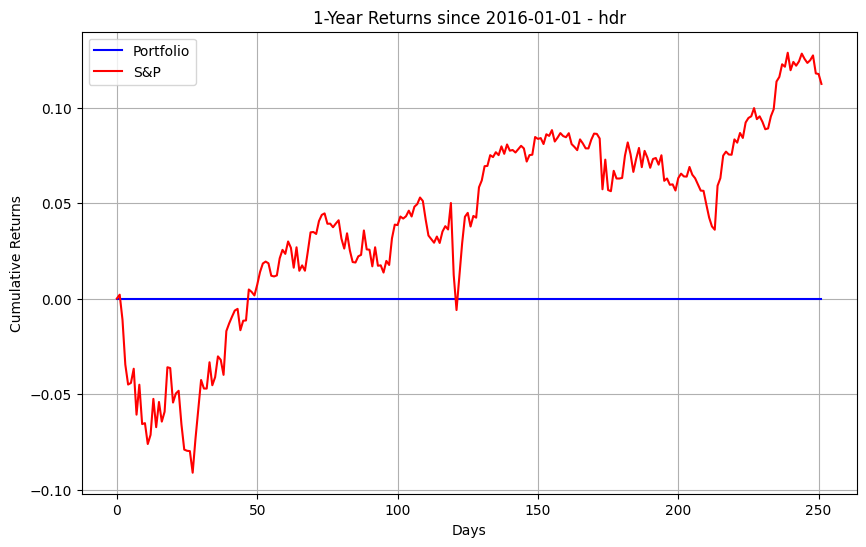

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


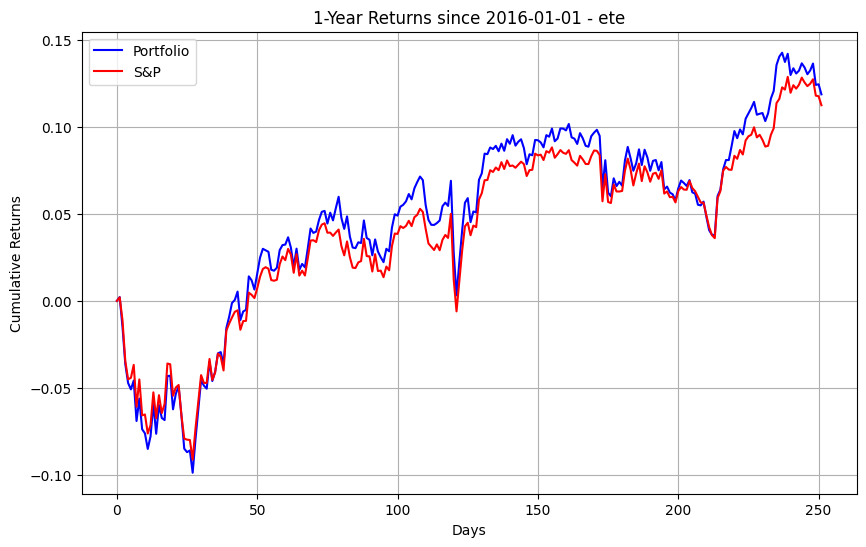

In [76]:
res_2015_5_hdr, mat_2015_5_hdr = run_tests("2015-01-01", error="hdr", flag="backtest", train_period=1, test_period=1)
res_2015_5_ete, mat_2015_5_ete = run_tests("2015-01-01", error="ete", flag="backtest", train_period=1, test_period=1)

In [64]:
res_2015_5_ete, mat_2015_5_ete = run_tests("2015-01-01", error="hdr", flag="backtest", train_period=1, test_period=4)
res_2015_5_ete, mat_2015_5_ete = run_tests("2015-01-01", error="ete", flag="backtest", train_period=1, test_period=4)


KeyboardInterrupt: 

[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
[*********************100%%**********************]  1 of 1 completed


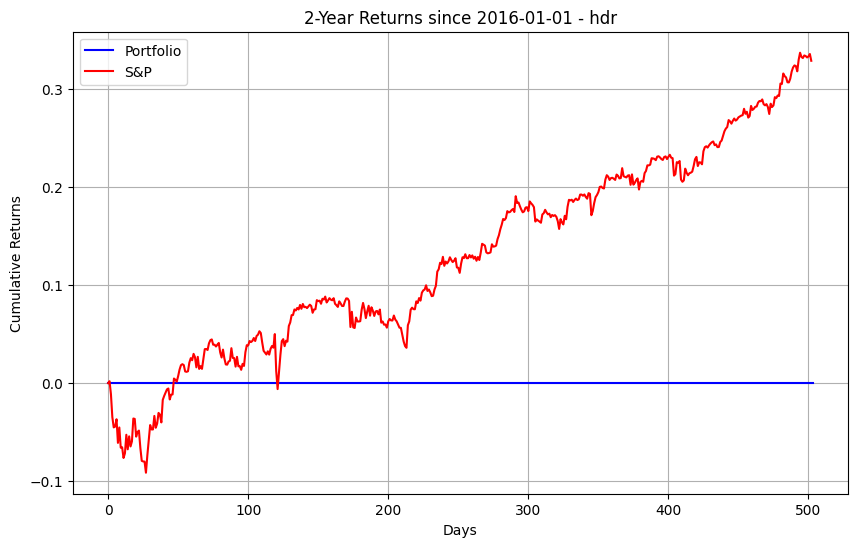

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


IndexError: list index out of range

In [67]:
res_2015_2_hdr, mat_2015_2_hdr = run_tests("2015-01-01", error="hdr", flag="backtest", train_period = 1, test_period = 2)
res_2015_2_ete, mat_2015_2_ete = run_tests("2015-01-01", error="ete", flag="backtest", train_period = 1, test_period = 2)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


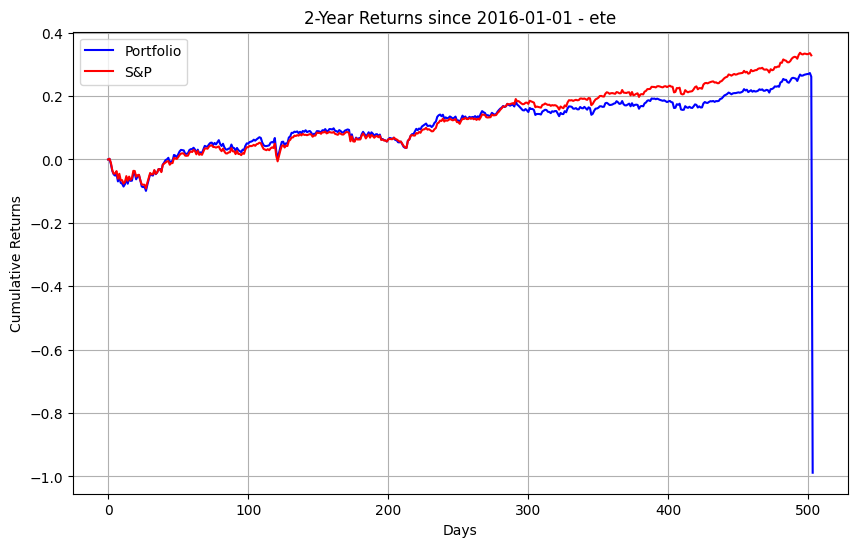

In [75]:
res_2015_3_ete, mat_2015_3_ete = run_tests("2015-01-01", error="ete", flag="backtest", train_period = 1, test_period = 2)


[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Number of NaNs in the original matrix: 10793


[*********************100%%**********************]  1 of 1 completed


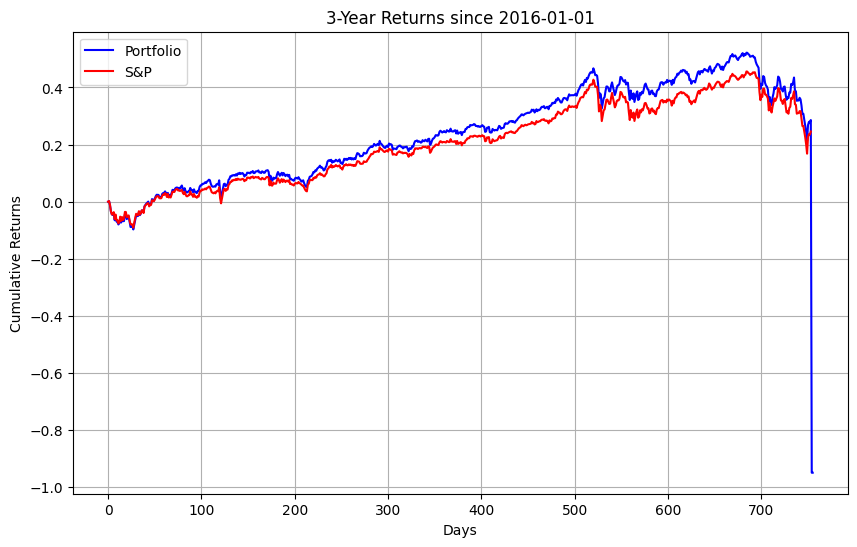

[*********************100%%**********************]  1 of 1 completed


Number of NaNs in the original matrix: 10793


[*********************100%%**********************]  1 of 1 completed


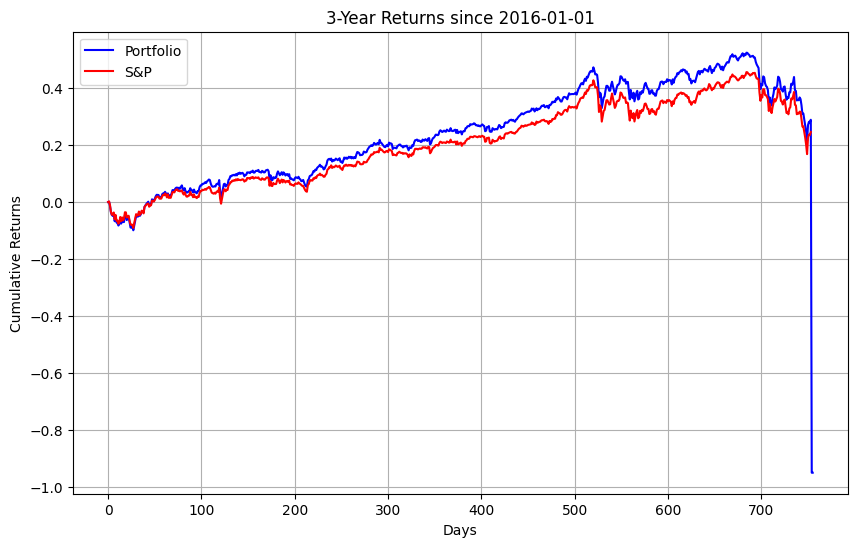

In [ ]:
res_2015_3_hdr, mat_2015_3_hdr = run_tests("2015-01-01", error="hdr", flag="backtest", train_period = 1, test_period = 1)
res_2015_3_ete, mat_2015_3_ete = run_tests("2015-01-01", error="ete", flag="backtest", train_period = 1, test_period = 1)

# Backtests - 2017

[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
[*********************100%%**********************]  1 of 1 completed


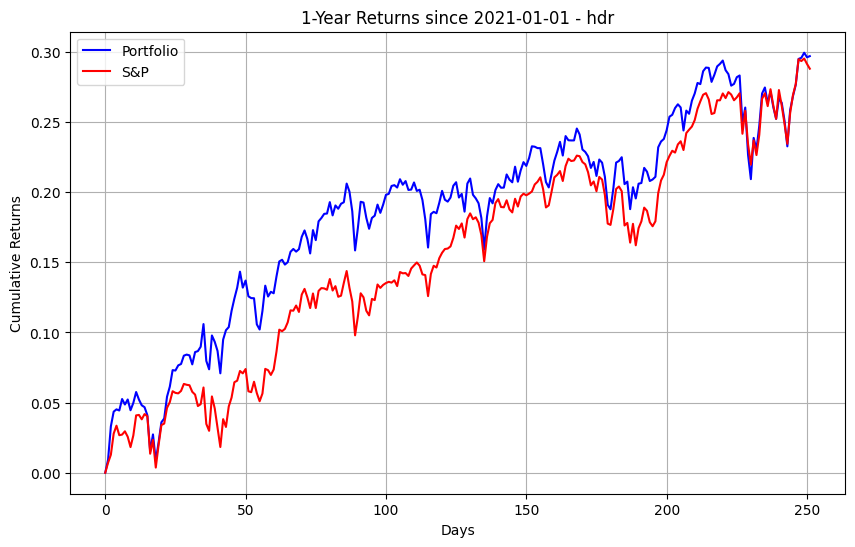

In [72]:
res_2017_5_hdr, mat_2017_5_hdr = run_tests("2020-01-01", error="hdr", flag="backtest", train_period = 1, test_period = 1)


[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
[*********************100%%**********************]  1 of 1 completed


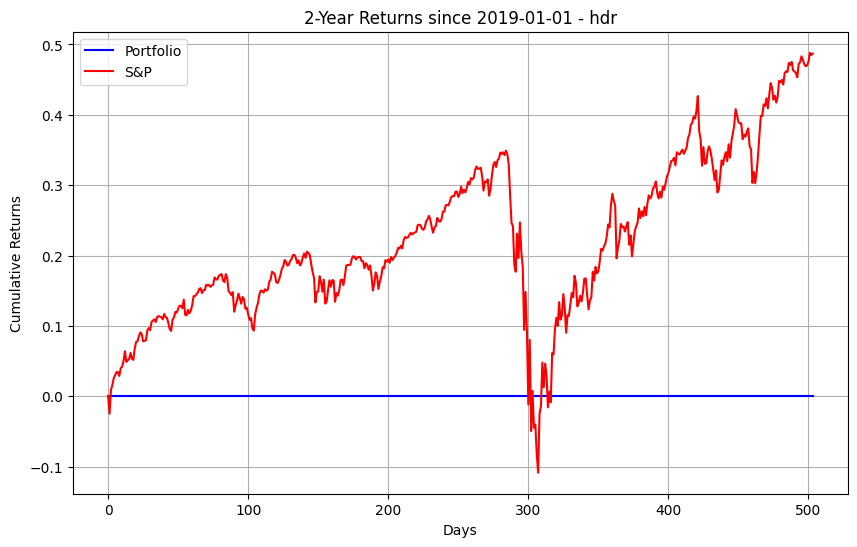

KeyboardInterrupt: 

In [73]:
res_2017_5_hdr, mat_2017_5_hdr = run_tests("2018-01-01", error="hdr", flag="backtest", train_period = 1, test_period = 2)
res_2017_5_ete, mat_2017_5_ete = run_tests("2018-01-01", error="ete", flag="backtest", train_period = 1, test_period = 2)

[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
[*********************100%%**********************]  1 of 1 completed


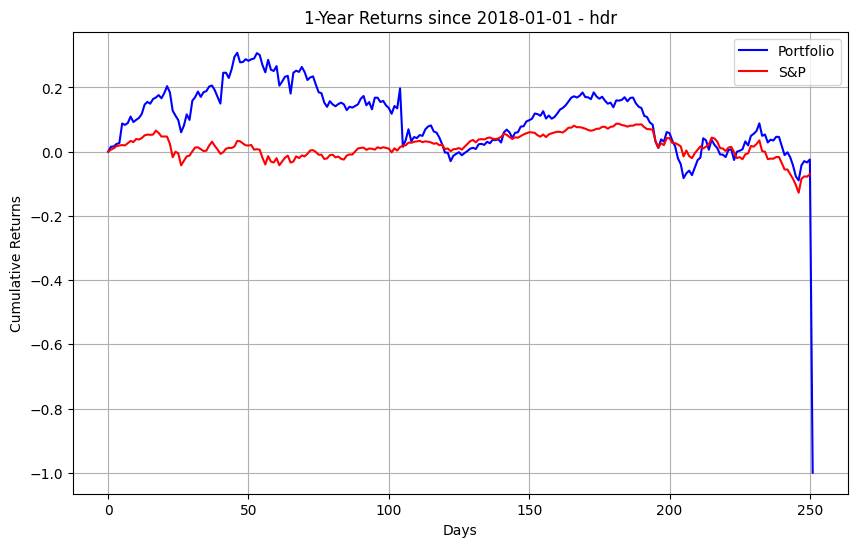

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


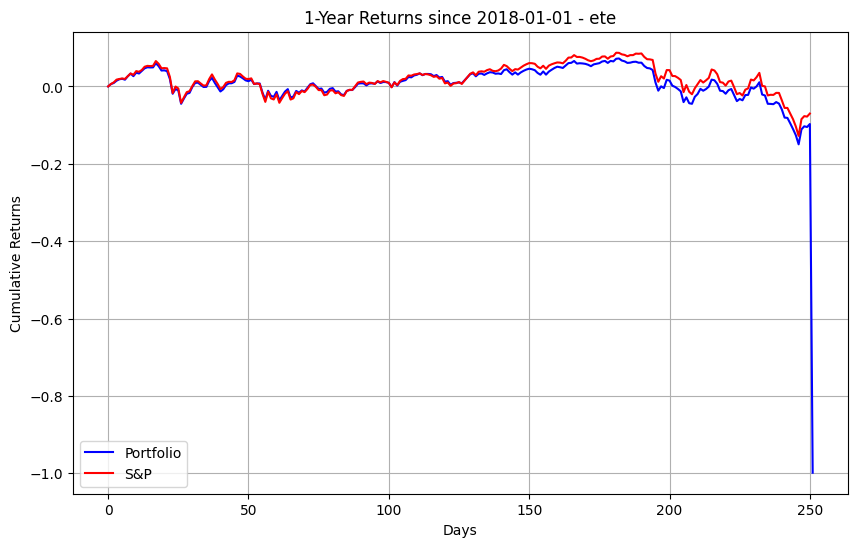

In [74]:
res_2017_5_hdr, mat_2017_2_hdr = run_tests("2017-01-01", error="hdr", flag="backtest", train_period = 1, test_period = 1)
res_2017_5_ete, mat_2017_2_ete = run_tests("2017-01-01", error="ete", flag="backtest", train_period = 1, test_period = 1)

[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
[*********************100%%**********************]  1 of 1 completed


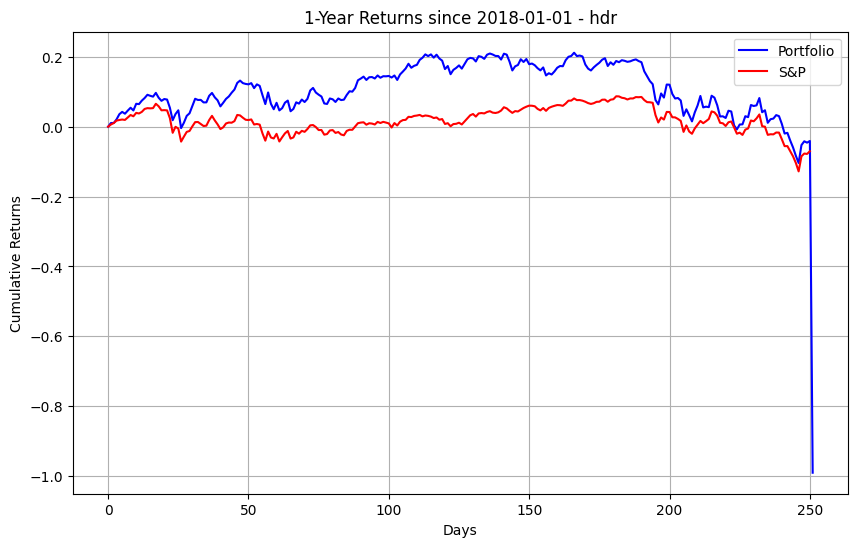

[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
[*********************100%%**********************]  1 of 1 completed


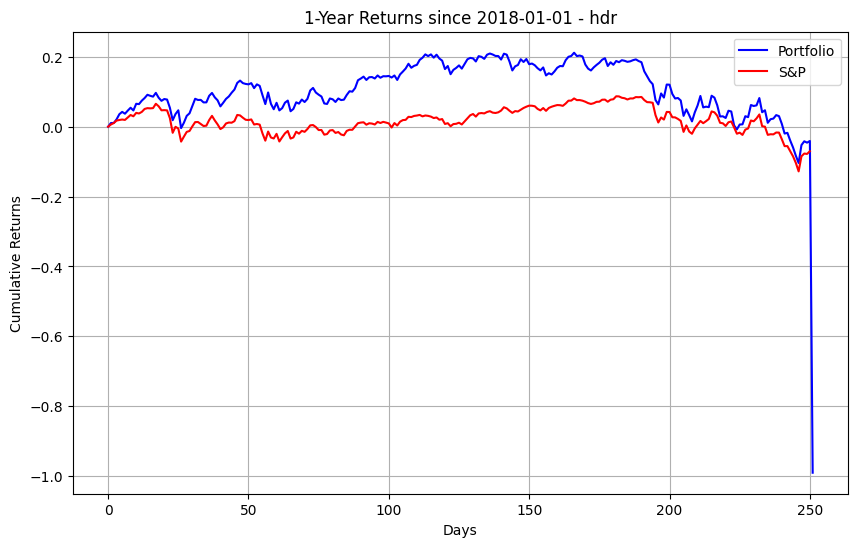

In [ ]:
res_2017_3_hdr, mat_2017_3_hdr = run_tests("201-01-01", error="hdr", flag="backtest", train_period = 1, test_period = 1)
res_2017_3_ete, mat_2017_3_ete = run_tests("2017-01-01", error="hdr", flag="backtest", train_period = 1, test_period = 1)

# Backtests - 2021

[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Number of NaNs in the original matrix: 2259


[*********************100%%**********************]  1 of 1 completed


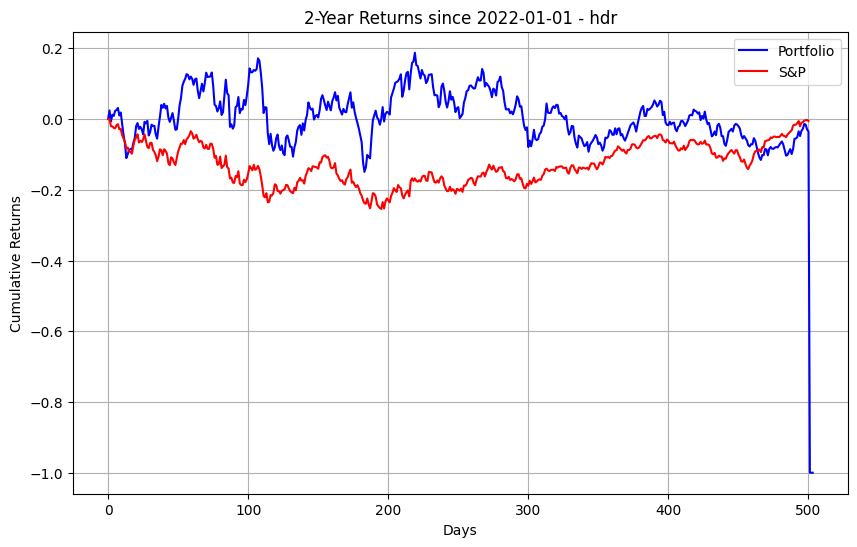

[*********************100%%**********************]  1 of 1 completed


Number of NaNs in the original matrix: 2259


[*********************100%%**********************]  1 of 1 completed


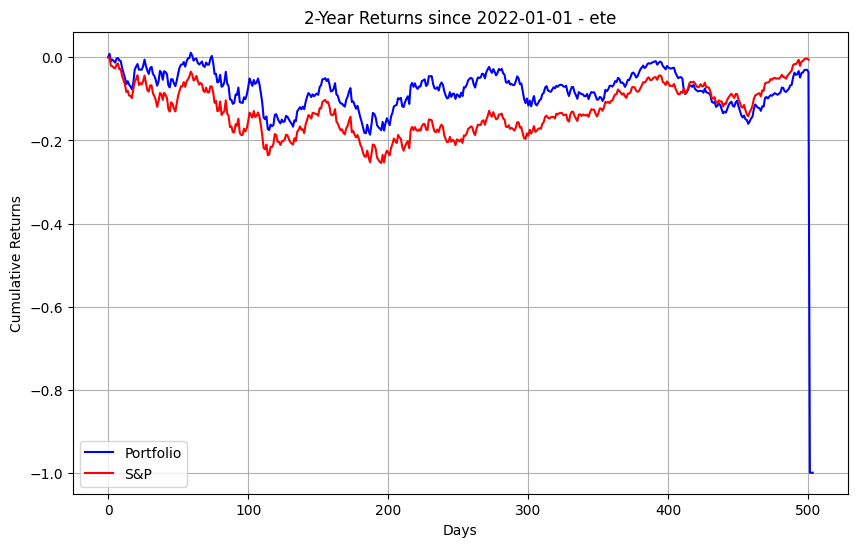

In [ ]:
res_2021_2_hdr, mat_2021_2_hdr = run_tests("2021-01-01", error="hdr", flag="backtest", train_period = 1, test_period=2)
res_2021_2_ete, mat_2021_2_ete = run_tests("2021-01-01", error="ete", flag="backtest", train_period = 1, test_period=2)

[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Number of NaNs in the original matrix: 2259


[*********************100%%**********************]  1 of 1 completed


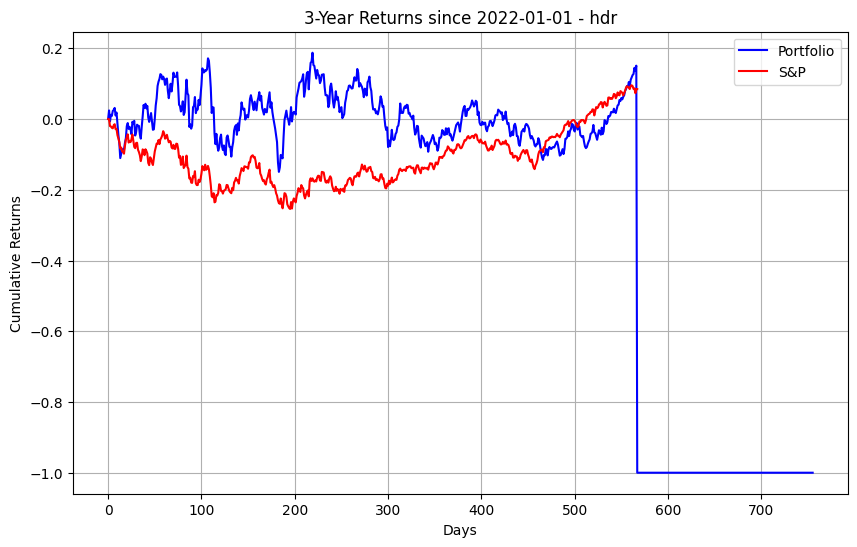

[*********************100%%**********************]  1 of 1 completed


Number of NaNs in the original matrix: 2259


[*********************100%%**********************]  1 of 1 completed


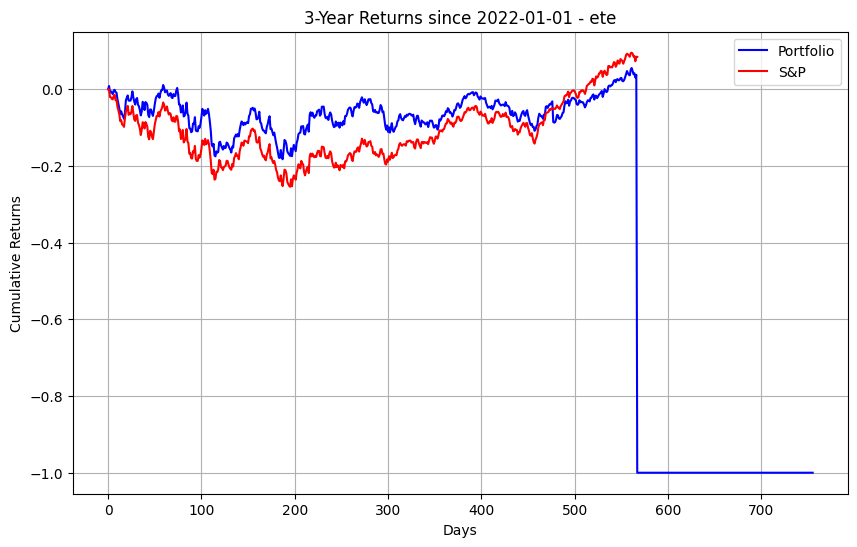

In [ ]:
res_2021_2_hdr, mat_2021_2_hdr = run_tests("2021-01-01", error="hdr", flag="backtest", train_period = 1, test_period=2)
res_2021_2_ete, mat_2021_2_ete = run_tests("2021-01-01", error="ete", flag="backtest", train_period = 1, test_period=2)

# Backtests-2010

[*********************100%%**********************]  1 of 1 completed
/Users/henrytang/Portfolio/sparse-index-tracking/myenv/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Number of NaNs in the original matrix: 21084


[*********************100%%**********************]  1 of 1 completed


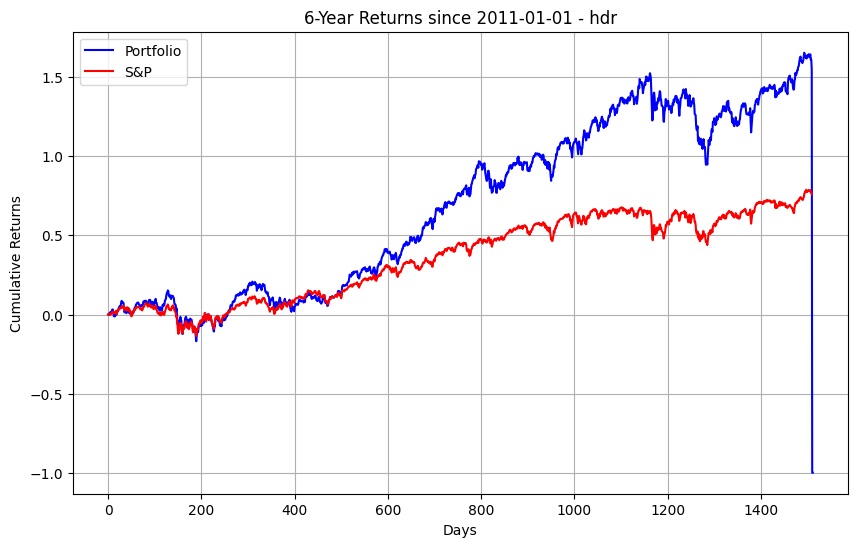

[*********************100%%**********************]  1 of 1 completed


Number of NaNs in the original matrix: 21084


[*********************100%%**********************]  1 of 1 completed


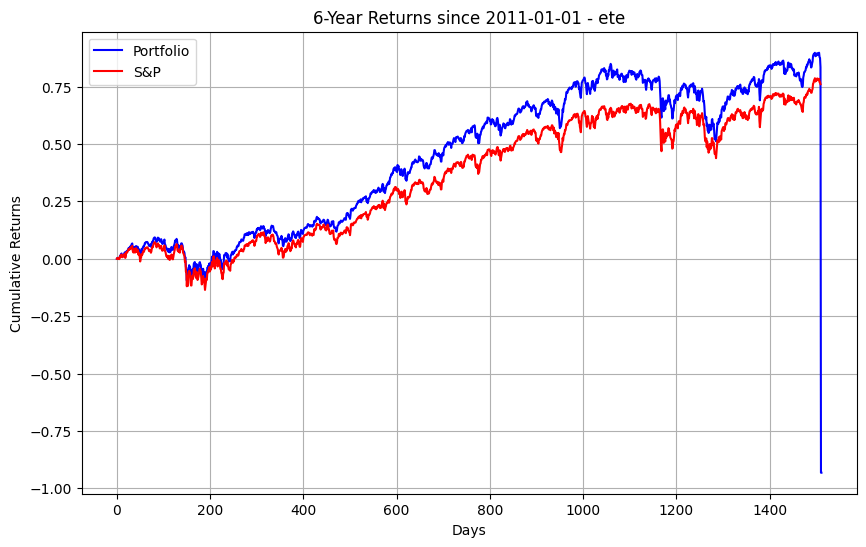

In [ ]:
res_2022_1_hdr, mat_2022_2_hdr = run_tests("2010-01-01", error="hdr", flag="backtest", train_period = 1, test_period=6)
res_2022_1_ete, mat_2022_2_ete = run_tests("2010-01-01", error="ete", flag="backtest", train_period = 1, test_period=6)